In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

plt.rcdefaults()

In [33]:
snap_index = 0

In [34]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

In [35]:
omega_index = 2 # while we debug, we confine our attention to just one value
onh2 = spectra.omegas_nu[omega_index]
onh2_str = spectra.omnu_strings[omega_index]

In [36]:
# It's a waste of time to consider all of the omegas and snapshots, so we're
# making heavy use of skips.
spec_sims = spectra.better_battery(spectra.omegas_nu, spectra.omnu_strings,
    skips_omega = [0, 1], skips_model=[8], skips_snapshot=[1, 2, 3],
    h_units=False)

In [37]:
data = spec_sims[onh2_str]
dTitle = "Lukas"

fig, axs = plt.subplots()
spectra.model_ratios_true(
    4, spec_sims[onh2_str], axs, massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title="Simulation attempt");

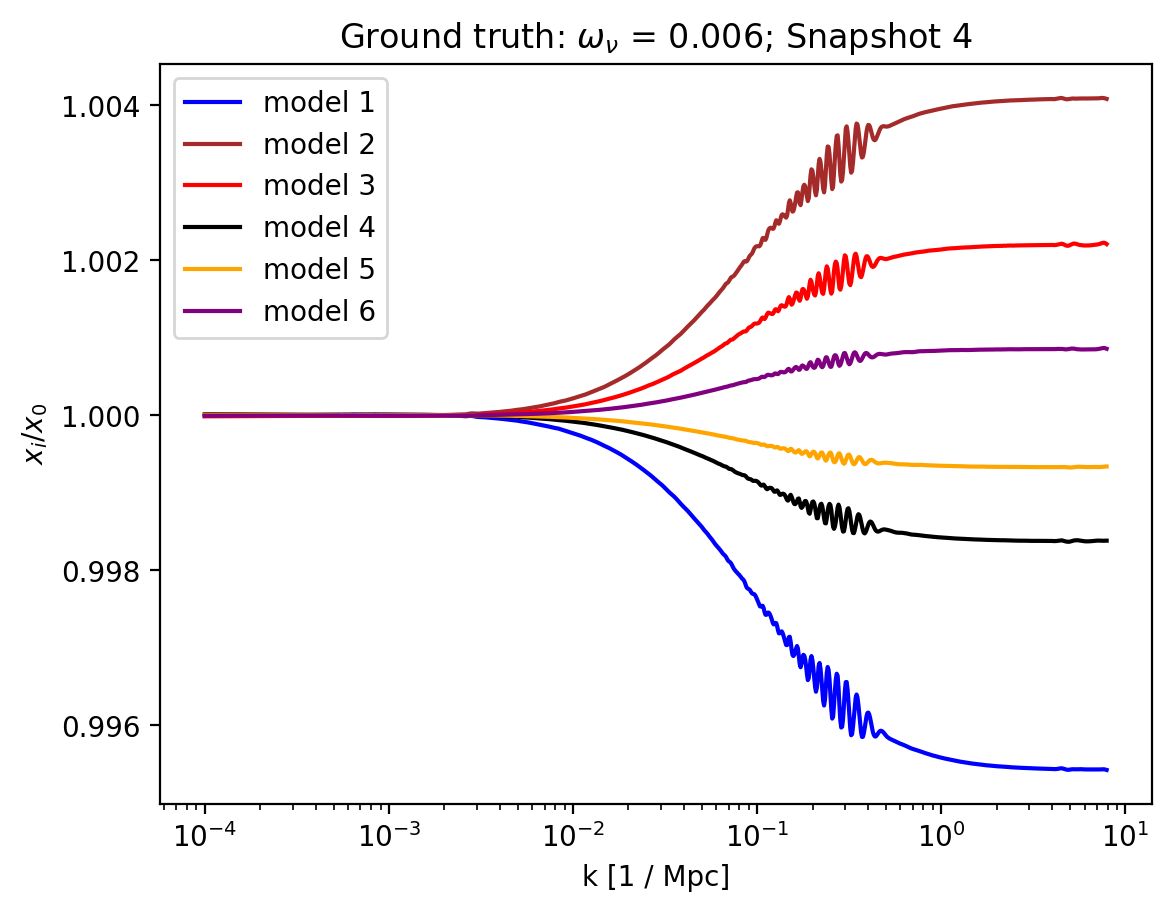

In [38]:
fig, axs = plt.subplots()
spectra.model_ratios_true(4, spectra.powernu[onh2_str], axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str);

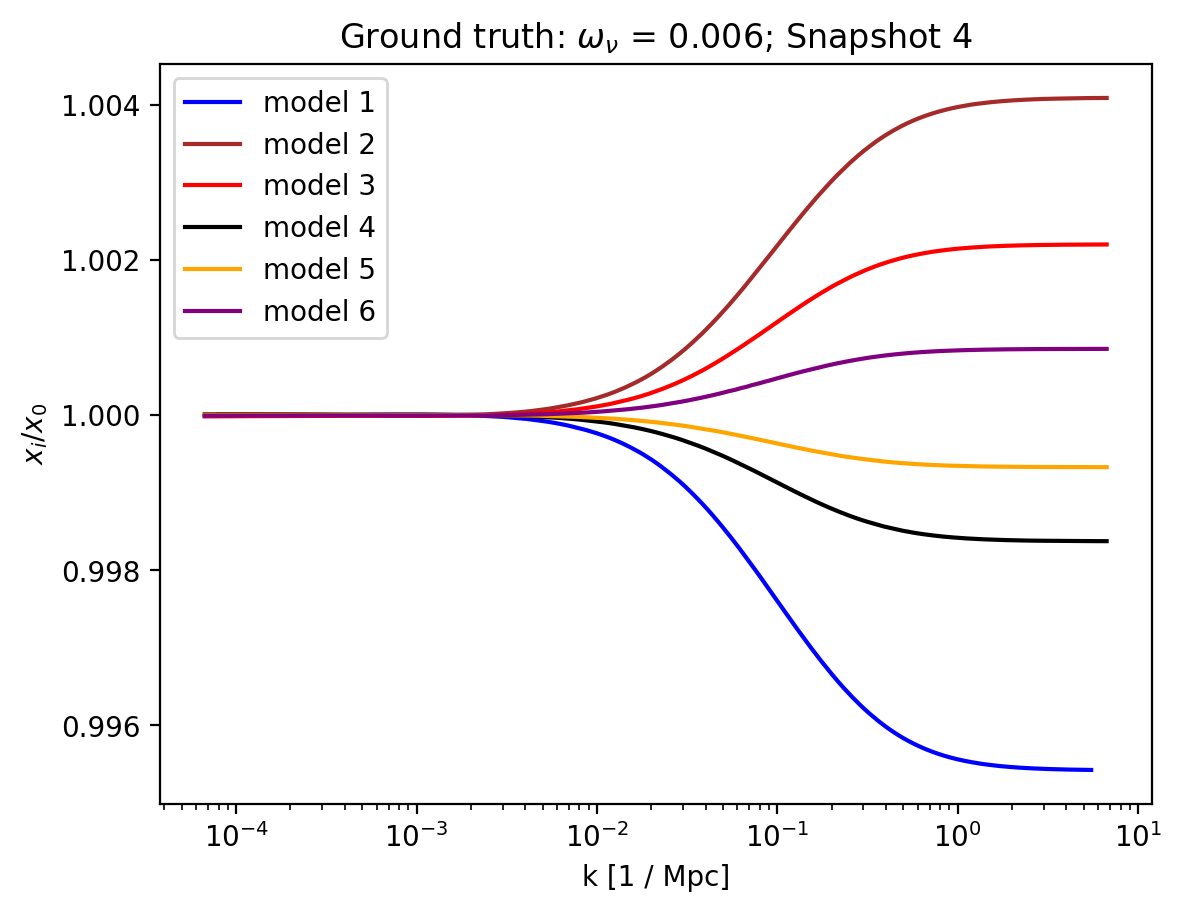

In [39]:
fig, axs = plt.subplots()
ks, rats = spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str);

In [40]:
# Be careful with the indexing here; rats[0] is the ratio of model 1 to model 0
true_asymptotes = np.array([rats[i][len(rats[i]) - 1] for i in range(len(rats))])
zc_asymptotes = true_asymptotes - 1

In [41]:
true_asymptotes

array([0.99542523, 1.00408923, 1.00219981, 0.99837482, 0.99932901,
       1.00085399])

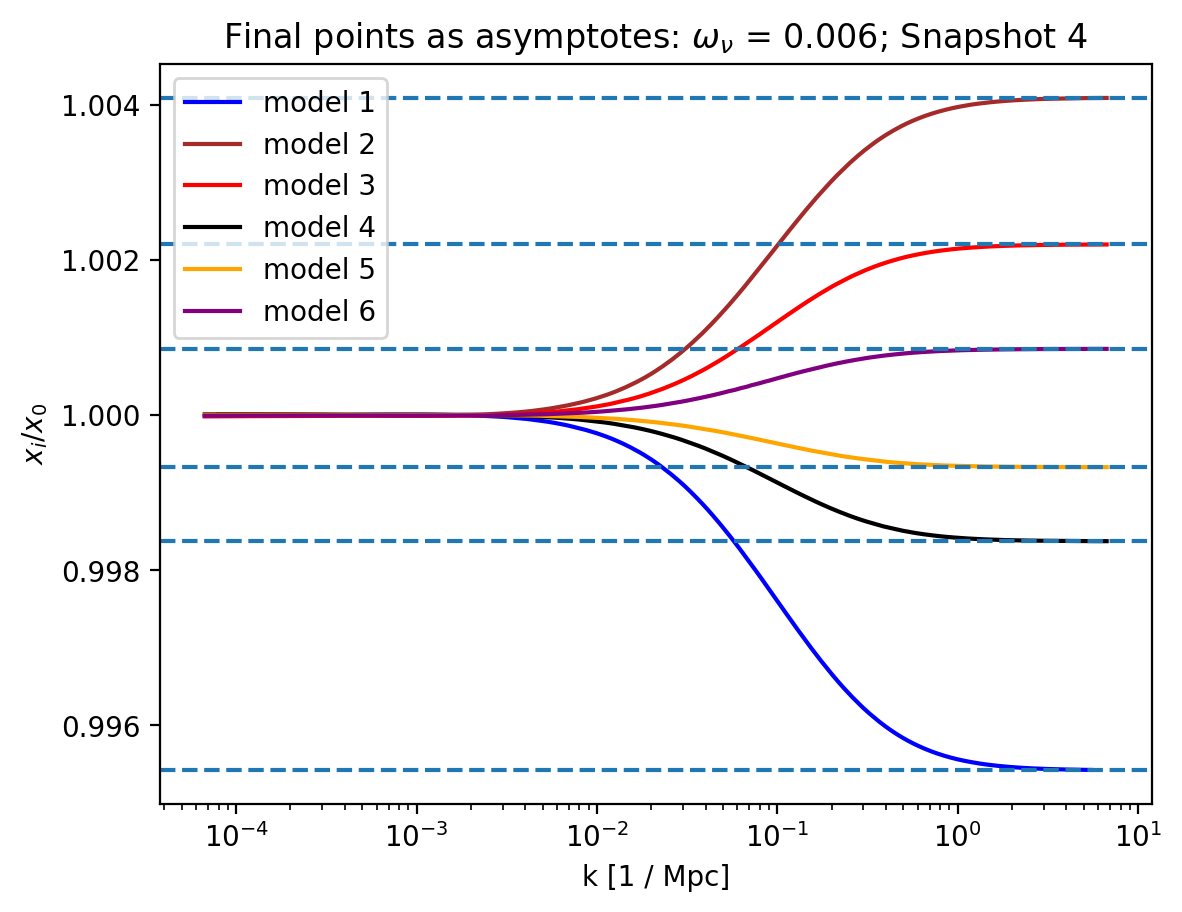

In [42]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title="Final points as asymptotes")
for asymptote in true_asymptotes:
    axs.axhline(asymptote, linestyle='--')

y-intercept for this fit is 0.9737448626011435
slope for this fit is 4.106976787235396
[5.39543249e-08 2.19210658e-08 5.36134260e-10 2.02085963e-08
 2.99759611e-08 7.77929370e-09]
Reduced chi squared value for this fit: 2.242869364814784e-08


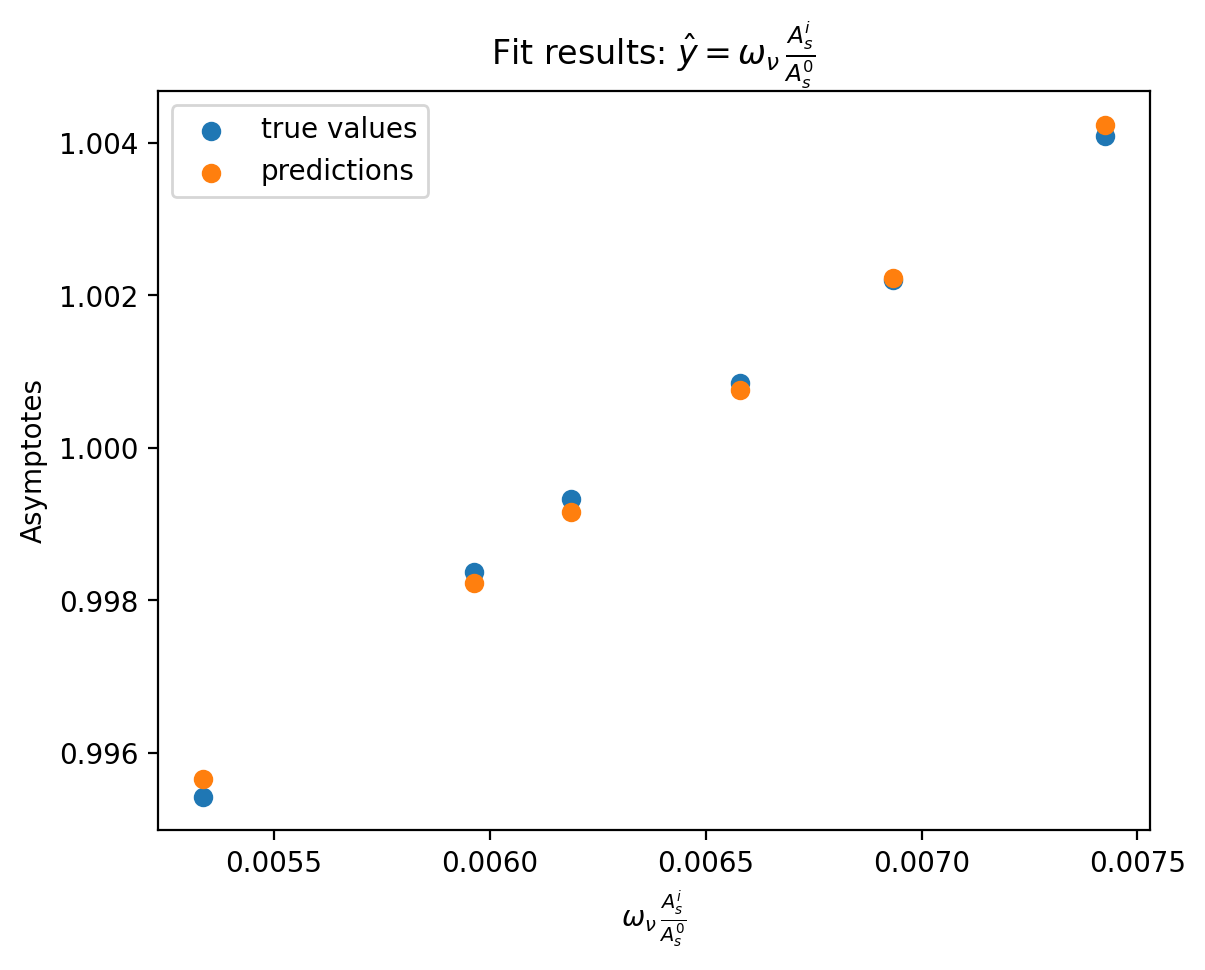

In [43]:
A_s = [spectra.cosm.loc[i]["A_s"] for i in range(7)]
from numpy.polynomial.polynomial import polyfit

x1 = onh2 * (A_s[1:] / A_s[0])
model_desc_1 = r"\omega_\nu \, \frac{A_s^i}{A_s^0}$"

plt.scatter(x1, true_asymptotes, label="true values")

b1, m1 = polyfit(x1, true_asymptotes, 1)
pred1 = m1 * x1 + b1 

plt.scatter(x1, pred1, label="predictions")
print("y-intercept for this fit is", b1)
print("slope for this fit is", m1)
print(np.square(true_asymptotes - pred1))

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_1)
plt.title(r"Fit results: $\hat{y} = " + model_desc_1)
plt.legend()

chis1 = (true_asymptotes - pred1) ** 2 / pred1
red_chisq1 = sum(chis1) / len(x1)
print("Reduced chi squared value for this fit:", red_chisq1)

In [44]:
pred1

array([0.99565751, 1.00423728, 1.00222296, 0.99823267, 0.99915587,
       1.00076579])

In [45]:
from sklearn.linear_model import LinearRegression
reg_b_centered_noyint = LinearRegression()
reg_b_centered_noyint.fit_intercept=False
X = x1.reshape(-1, 1)
fit_b_centered_noyint = reg_b_centered_noyint.fit(X, zc_asymptotes)
m_centered_noyint = fit_b_centered_noyint.coef_[0]
b_centered_noyint = fit_b_centered_noyint.intercept_
print("slope for this fit is", m_centered_noyint, b_centered_noyint)

slope for this fit is 0.0521825865449237 0.0


In [46]:
reg_b_centered_yint = LinearRegression()
reg_b_centered_yint.fit_intercept=True
X = x1.reshape(-1, 1)
fit_b_centered_yint = reg_b_centered_yint.fit(X, zc_asymptotes)
m_centered_yint = fit_b_centered_yint.coef_[0]
b_centered_yint = fit_b_centered_yint.intercept_
print("slope for this fit is", m_centered_yint, b_centered_yint)

slope for this fit is 4.106976787235315 -0.026255137398855842


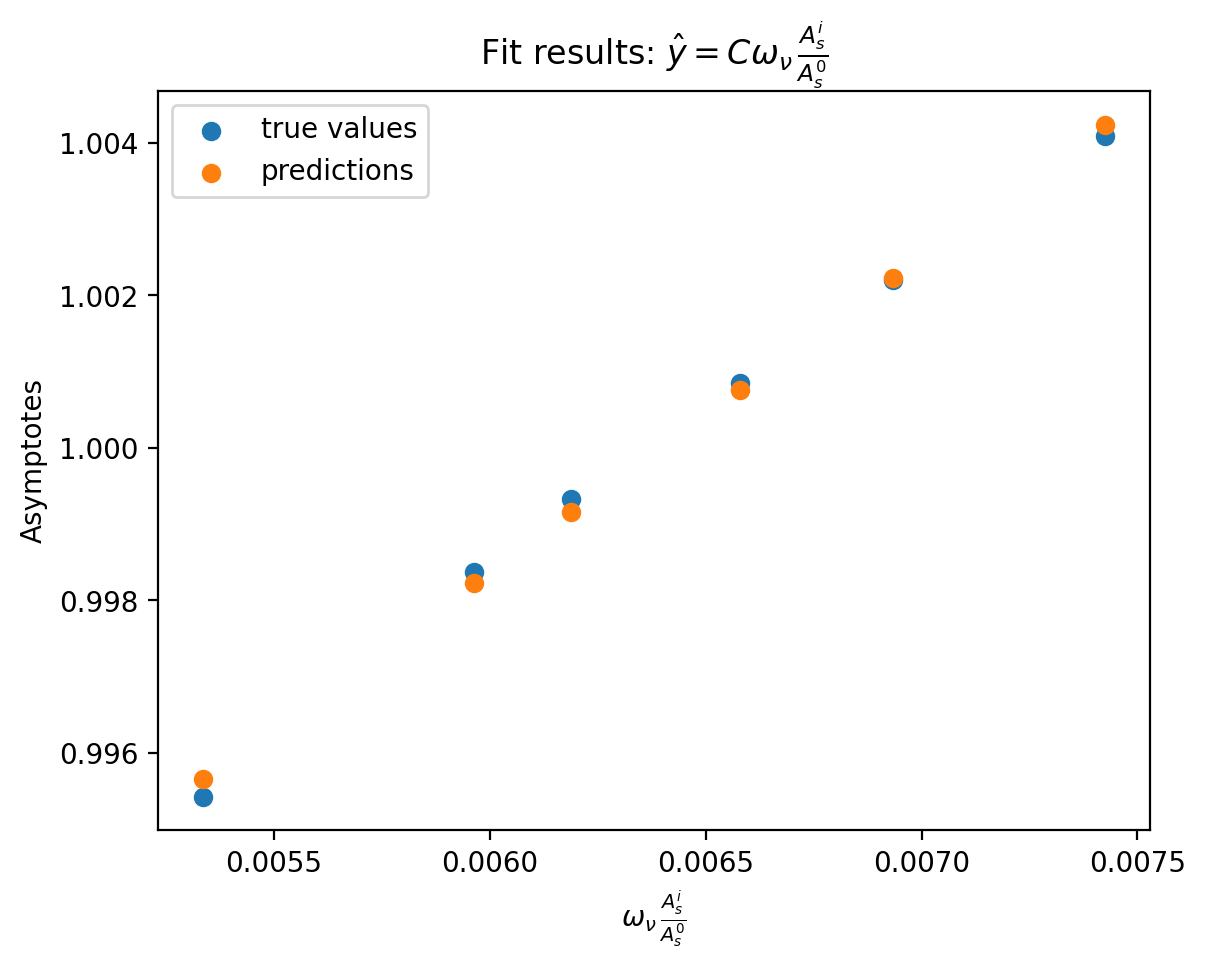

In [47]:
plt.scatter(x1, true_asymptotes, label="true values")
plt.scatter(x1, m1 * onh2 * (A_s[1:] / A_s[0]) + b1, label="predictions")

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_1)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_1)
plt.legend()

In [48]:
C = m1

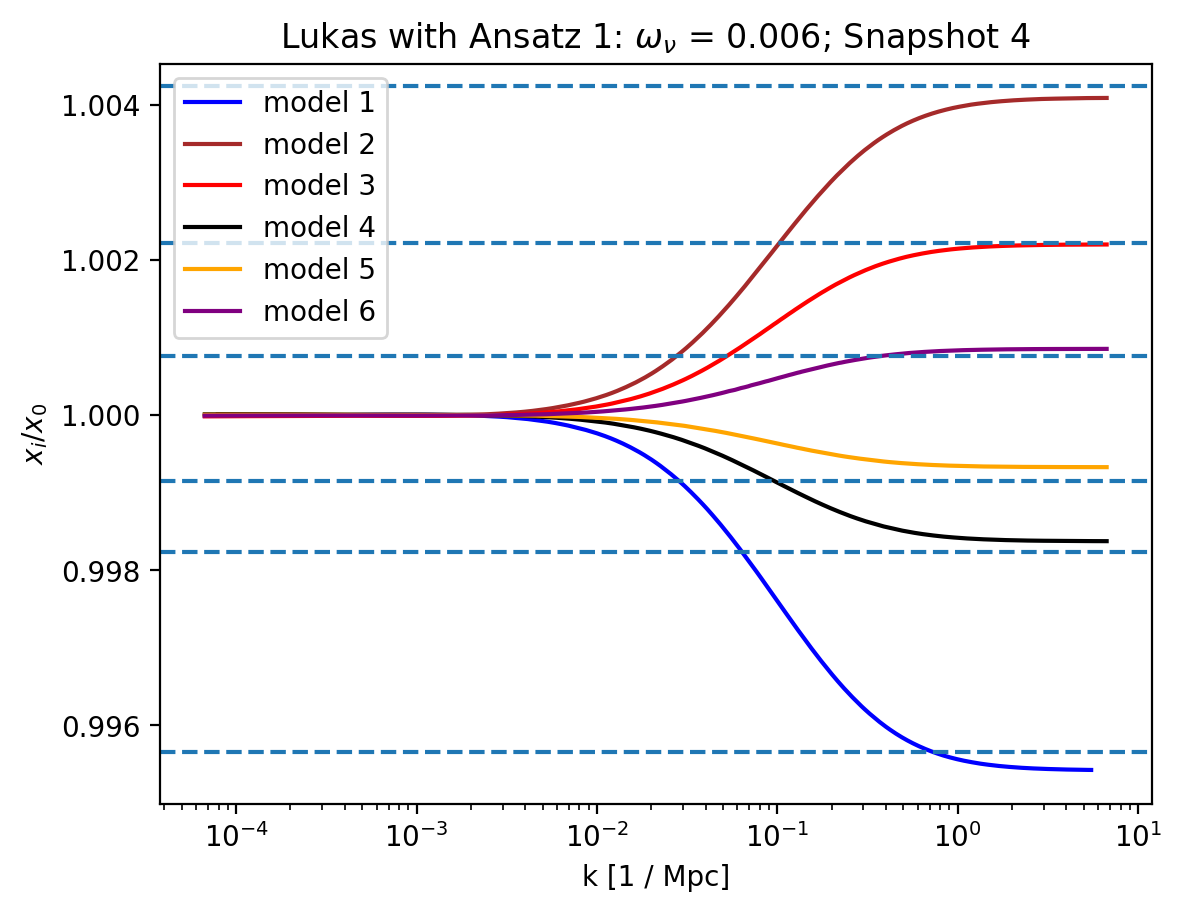

In [49]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title=dTitle + " with Ansatz 1");
for i in range(len(true_asymptotes)):
    axs.axhline(m1 * x1[i] + b1, linestyle='--')

y-intercept for this fit is 0.9477058807865409
slope for this fit is 8.215364981519741
Reduced chi squared value for this fit: 6.6726496639710446e-09


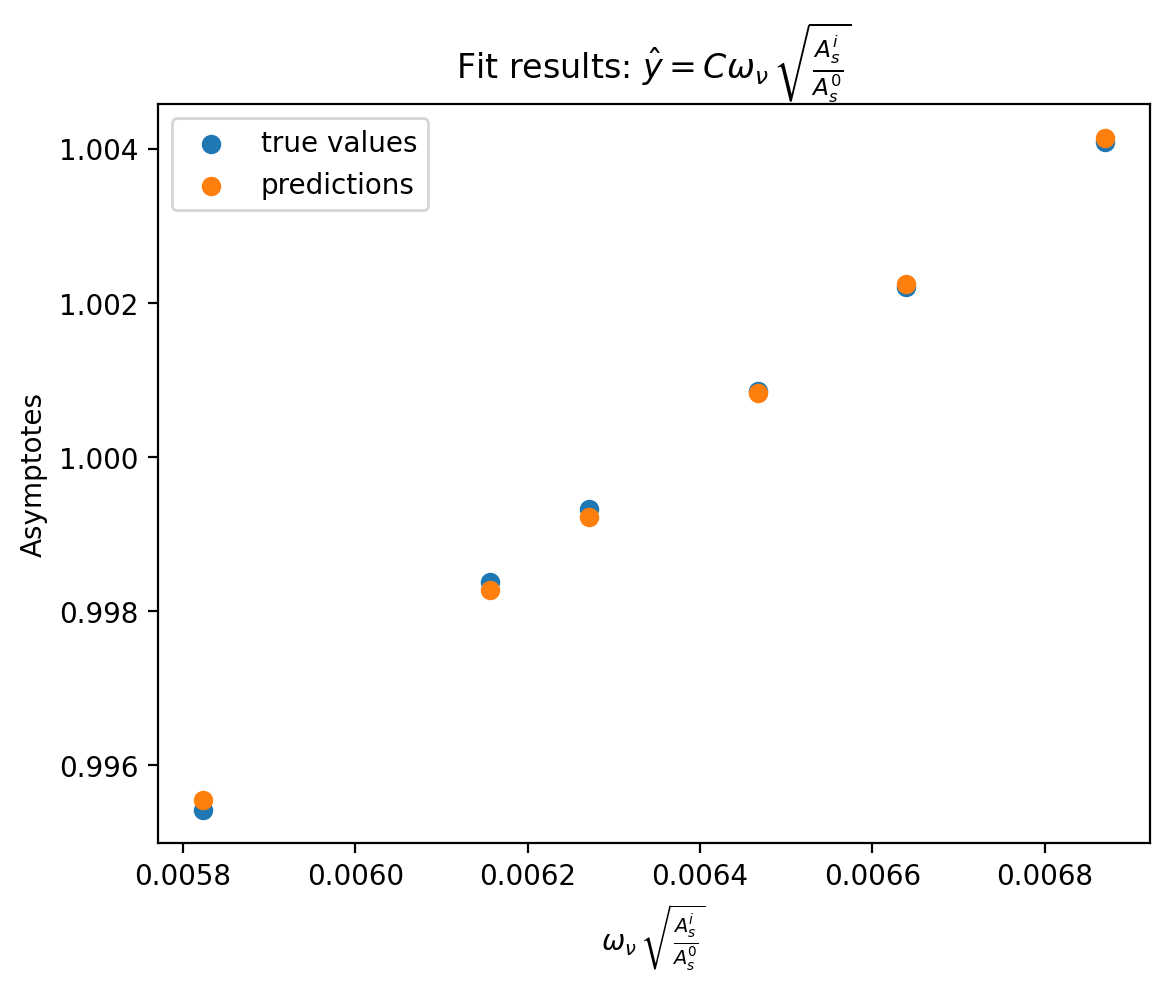

In [50]:
x2 = onh2 * np.sqrt(A_s[1:] / A_s[0])
model_desc_2 = r"\omega_\nu \, \sqrt{\frac{A_s^i}{A_s^0}}$"

plt.scatter(x2, true_asymptotes, label="true values")

b2, m2 = polyfit(x2, true_asymptotes, 1)

pred2 = m2 * x2 + b2
plt.scatter(x2, pred2, label="predictions")

print("y-intercept for this fit is", b2)
print("slope for this fit is", m2)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_2)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_2)
plt.legend()

chis2 = (true_asymptotes - pred2) ** 2 / pred2
red_chisq2 = sum(chis2) / len(x2)
print("Reduced chi squared value for this fit:", red_chisq2)

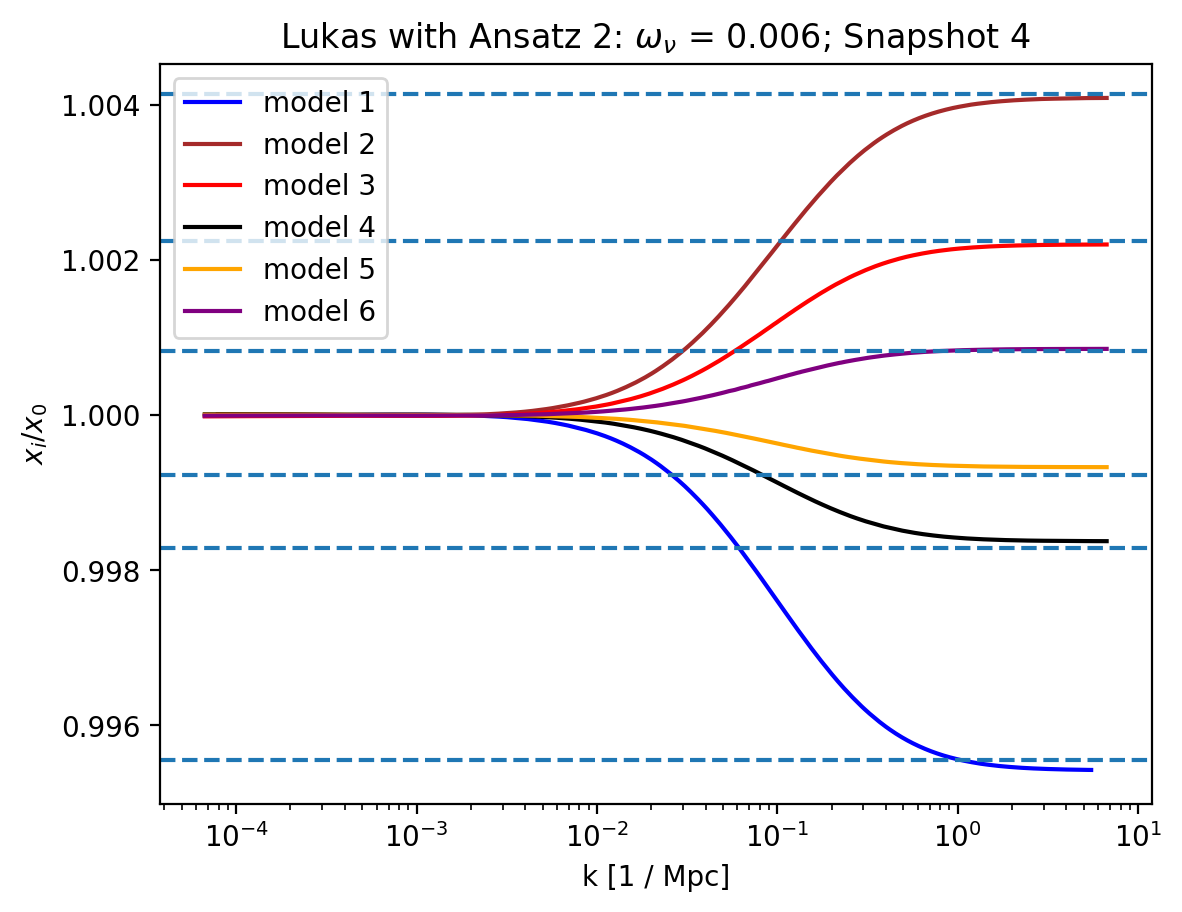

In [51]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title=dTitle + " with Ansatz 2");

for i in range(len(true_asymptotes)):
    axs.axhline(m2 * x2[i] + b2, \
        linestyle='--')

y-intercept for this fit is 0.9216758670927813
slope for this fit is 12.314605689851716
Reduced chi squared value for this fit: 3.836182932208557e-09


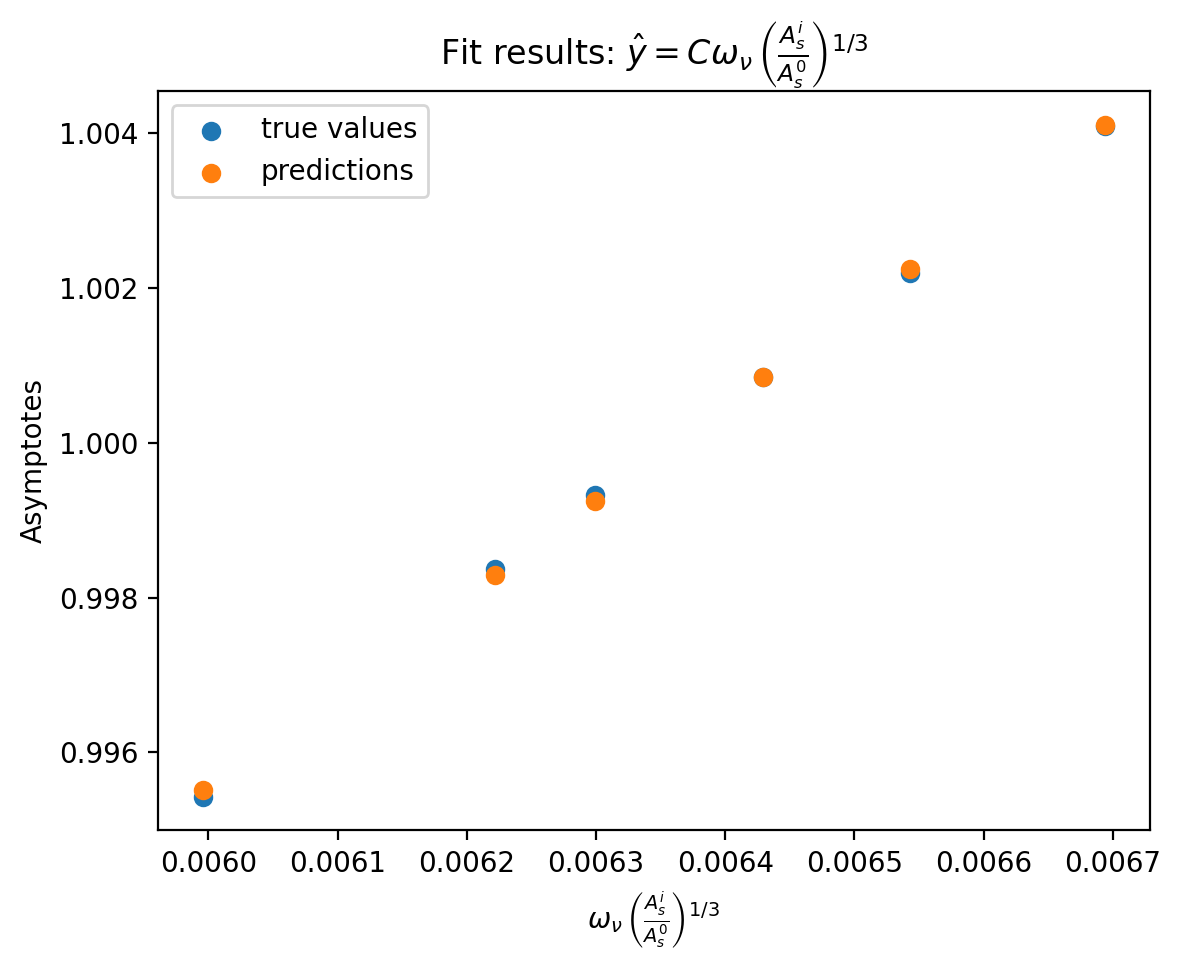

In [52]:
x3 = onh2 * np.power(A_s[1:] / A_s[0], 1/3)
model_desc_3 = r"\omega_\nu \, \left( \frac{A_s^i}{A_s^0} \right)^{1/3}$"

plt.scatter(x3, true_asymptotes, label="true values")

b3, m3 = polyfit(x3, true_asymptotes, 1)

pred3 = m3 * x3 + b3
plt.scatter(x3, pred3, label="predictions")

print("y-intercept for this fit is", b3)
print("slope for this fit is", m3)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_3)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_3)
plt.legend()

chis3 = (true_asymptotes - pred3) ** 2 / pred3
red_chisq3 = sum(chis3) / len(x3)
print("Reduced chi squared value for this fit:", red_chisq3)

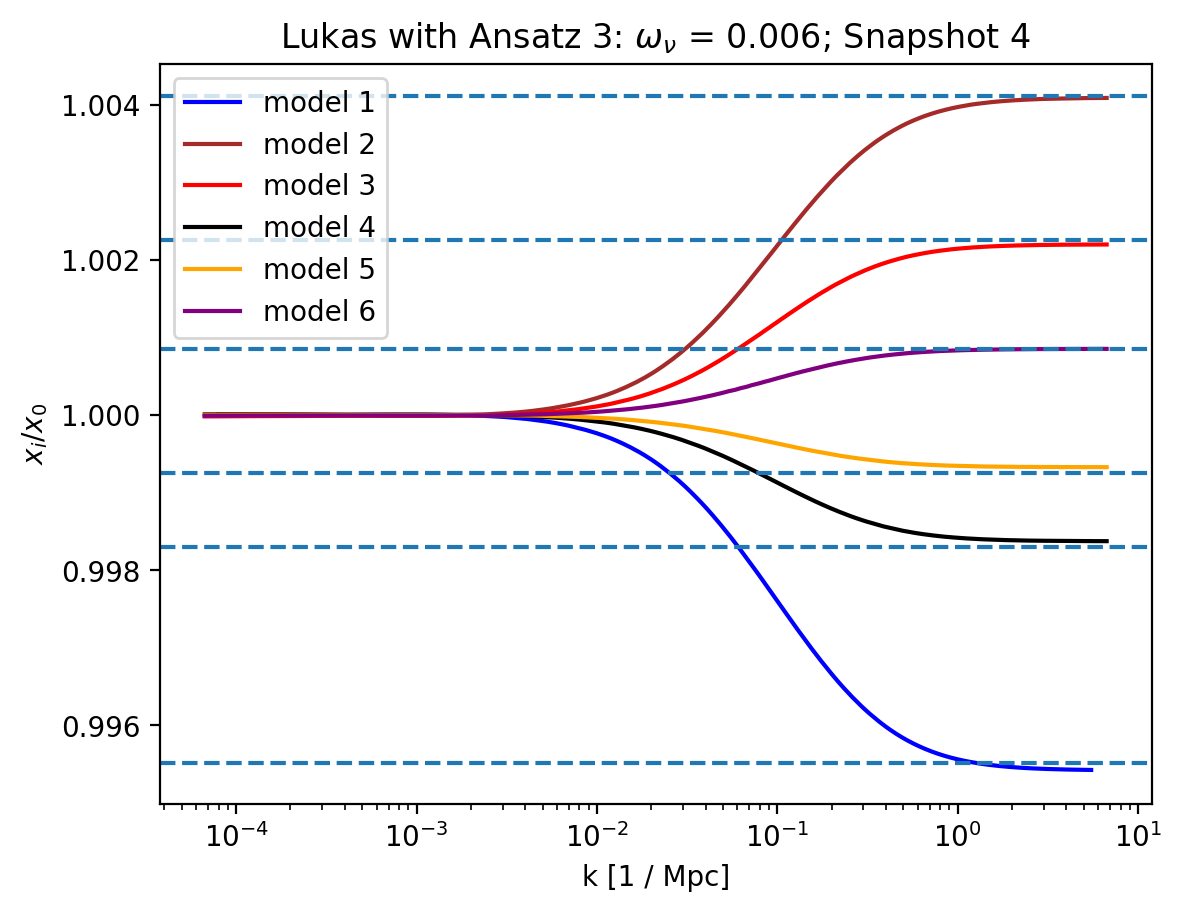

In [53]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title=dTitle + " with Ansatz 3")
for i in range(len(true_asymptotes)):
    axs.axhline(m3 * x3[i] + b3, linestyle='--')

y-intercept for this fit is 0.8956480534808394
slope for this fit is 16.411554154435
Reduced chi squared value for this fit: 2.8750644303878975e-09


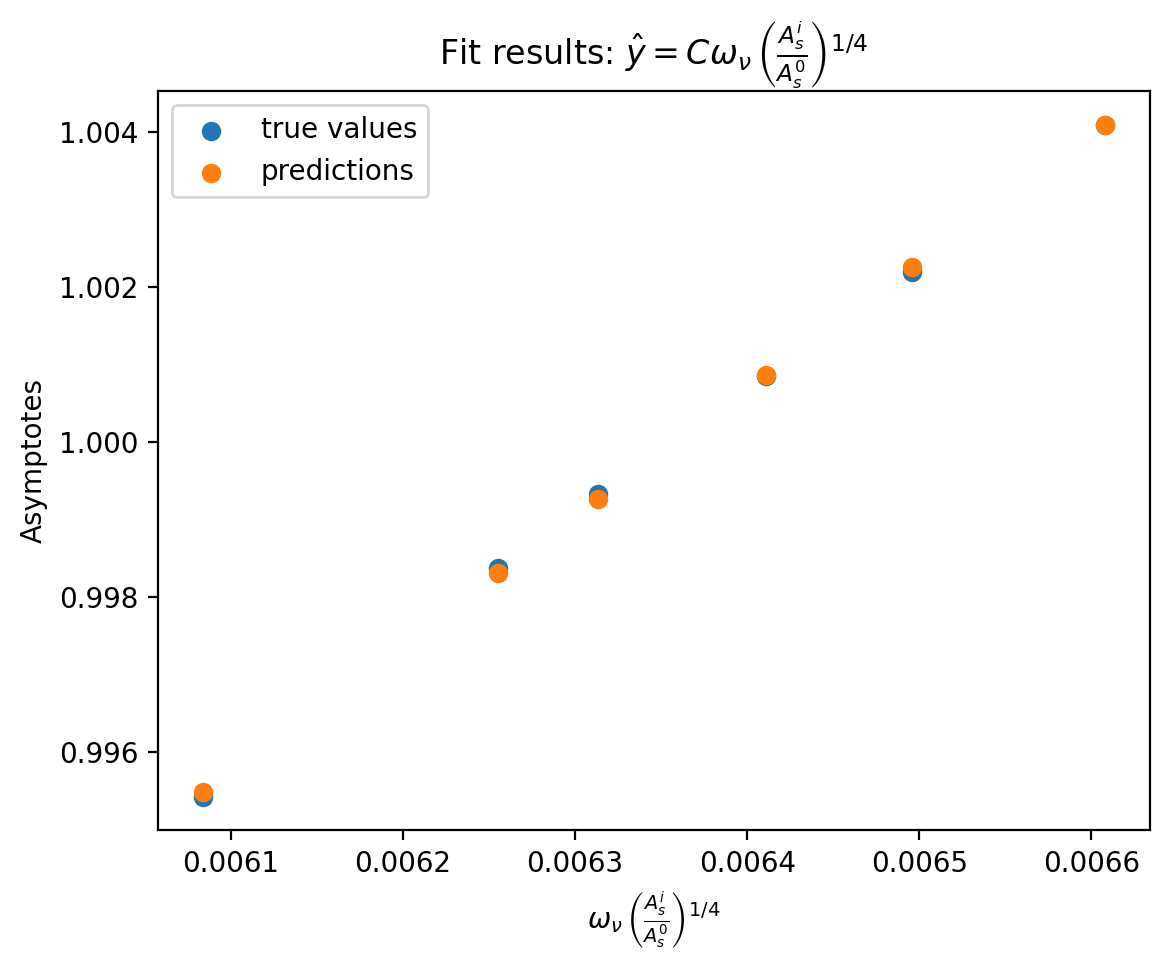

In [54]:
x4 = onh2 * np.power(A_s[1:] / A_s[0], 1/4)
model_desc_4 = r"\omega_\nu \, \left( \frac{A_s^i}{A_s^0} \right)^{1/4}$"

plt.scatter(x4, true_asymptotes, label="true values")

b4, m4 = polyfit(x4, true_asymptotes, 1)

pred4 = m4 * x4 + b4
plt.scatter(x4, pred4, label="predictions")

print("y-intercept for this fit is", b4)
print("slope for this fit is", m4)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_4)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_4)
plt.legend()

chis4 = (true_asymptotes - pred4) ** 2 / pred4
red_chisq4 = sum(chis4) / len(x4)
print("Reduced chi squared value for this fit:", red_chisq4)

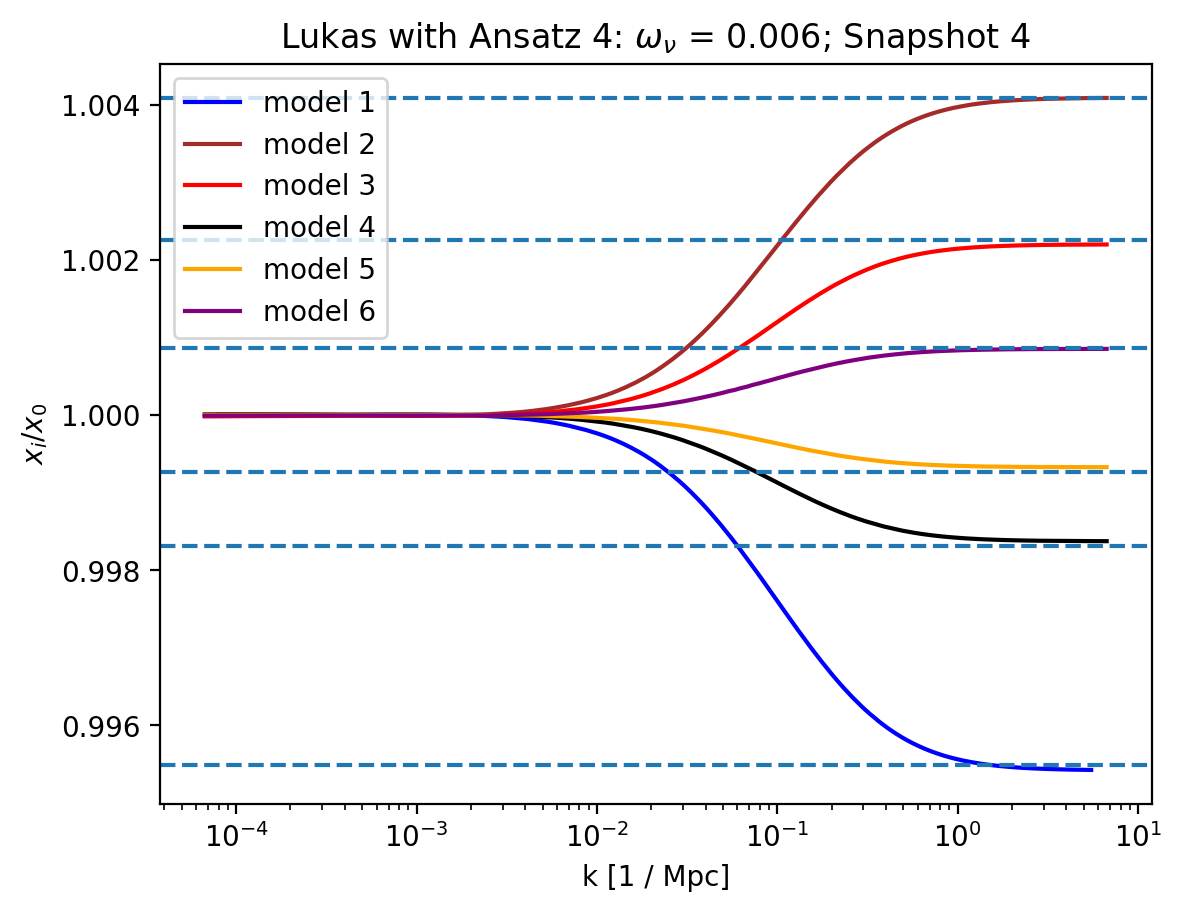

In [55]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title=dTitle + " with Ansatz 4")
for i in range(len(true_asymptotes)):
    axs.axhline(m4 * x4[i] + b4, linestyle='--')

y-intercept for this fit is 0.8696211115190166
slope for this fit is 20.507586008504695
Reduced chi squared value for this fit: 2.445035072388156e-09


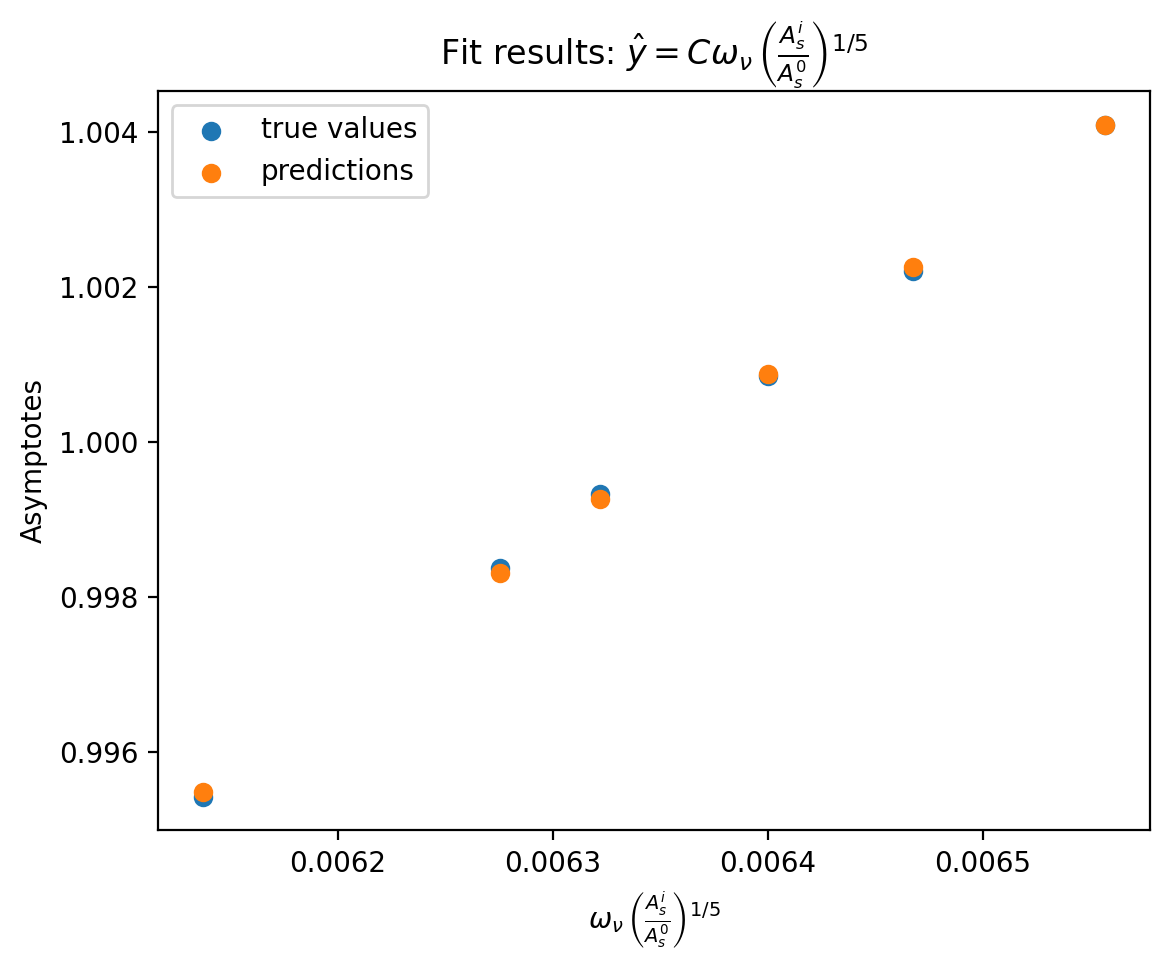

In [56]:
x5 = onh2 * np.power(A_s[1:] / A_s[0], 1/5)
model_desc_5 = r"\omega_\nu \, \left( \frac{A_s^i}{A_s^0} \right)^{1/5}$"

plt.scatter(x5, true_asymptotes, label="true values")

b5, m5 = polyfit(x5, true_asymptotes, 1)

pred5 = m5 * x5 + b5
plt.scatter(x5, pred5, label="predictions")

print("y-intercept for this fit is", b5)
print("slope for this fit is", m5)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_5)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_5)
plt.legend()

chis5 = (true_asymptotes - pred5) ** 2 / pred5
red_chisq5 = sum(chis5) / len(x5)
print("Reduced chi squared value for this fit:", red_chisq5)

In [57]:
pred5

array([0.99548356, 1.00408188, 1.0022565 , 0.99831182, 0.99926785,
       1.00087049])

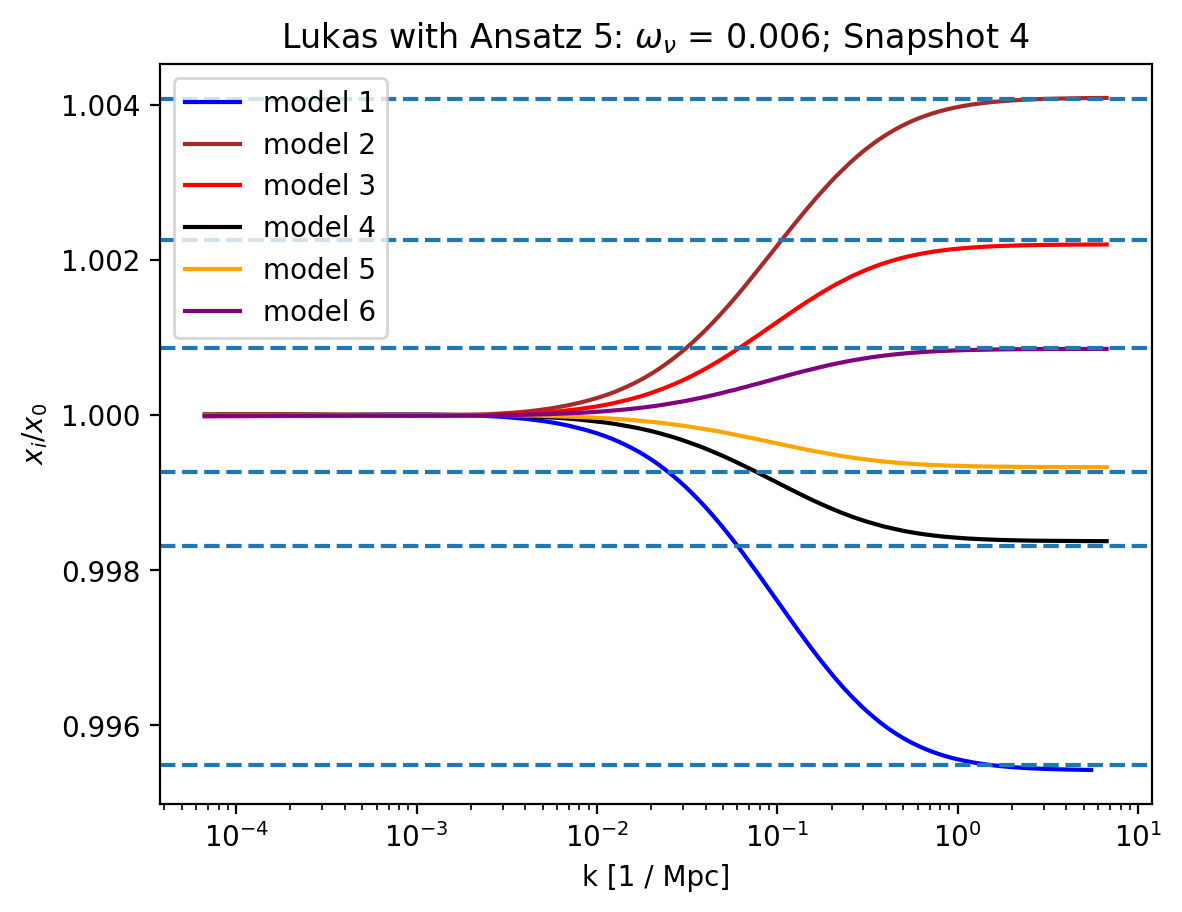

In [58]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title=dTitle + " with Ansatz 5")
for i in range(len(true_asymptotes)):
    axs.axhline(m5 * x5[i] + b5, linestyle='--')

Text(0, 0.5, 'Reduced chi squared goodness of fit')

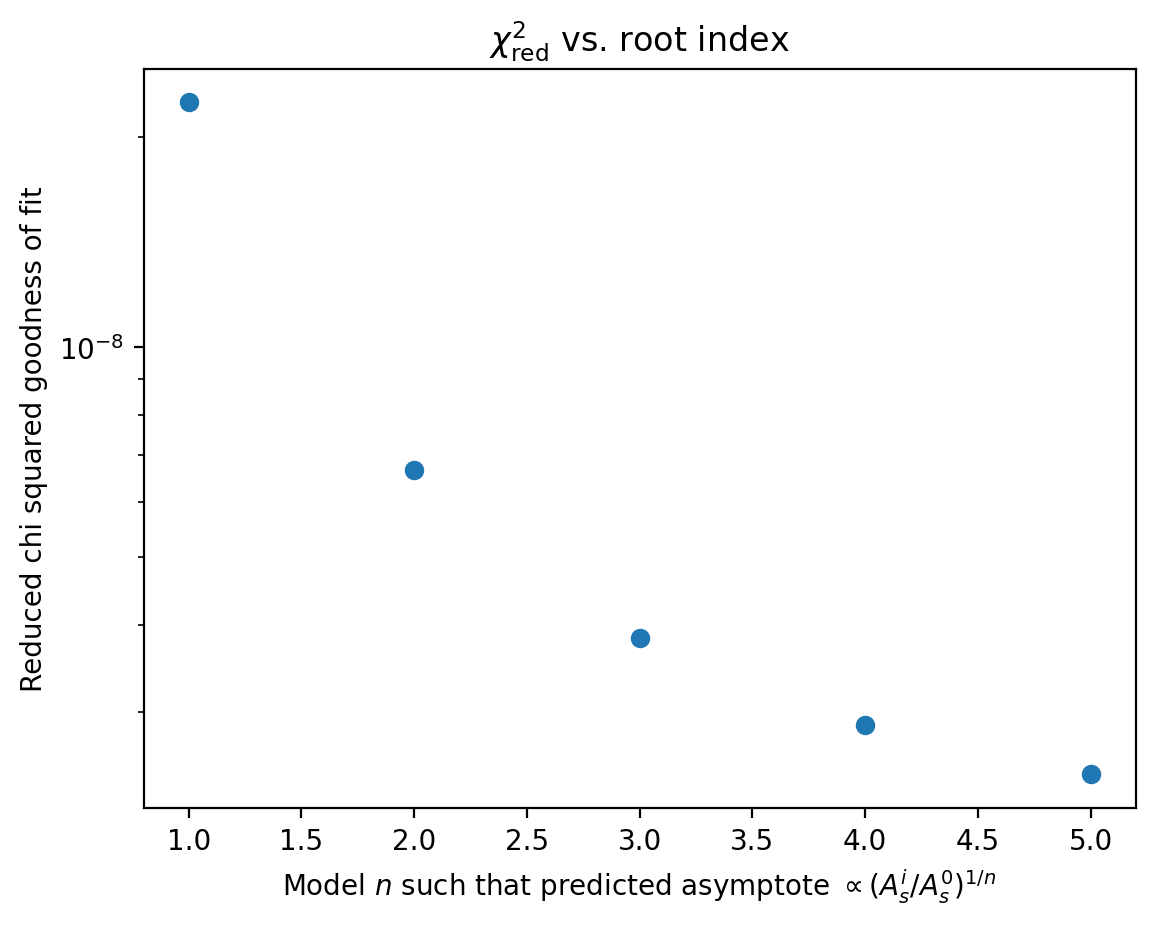

In [59]:
n = np.array(list(range(1, 6)))
red_chisqs = np.array([red_chisq1, red_chisq2, red_chisq3, red_chisq4,
    red_chisq5])
plt.scatter(n, red_chisqs)
plt.yscale('log')
plt.title(r"$\chi_\mathrm{red}^2$ vs. root index")
plt.xlabel(r"Model $n$ such that predicted asymptote " +
           "$\propto (A_s^i / A_s^0)^{1/n}$")
plt.ylabel("Reduced chi squared goodness of fit")

y-intercept for this fit is 0.9999970773658287
slope for this fit is 4.094658620435081
Reduced chi squared value for this fit: 1.826855111322315e-09


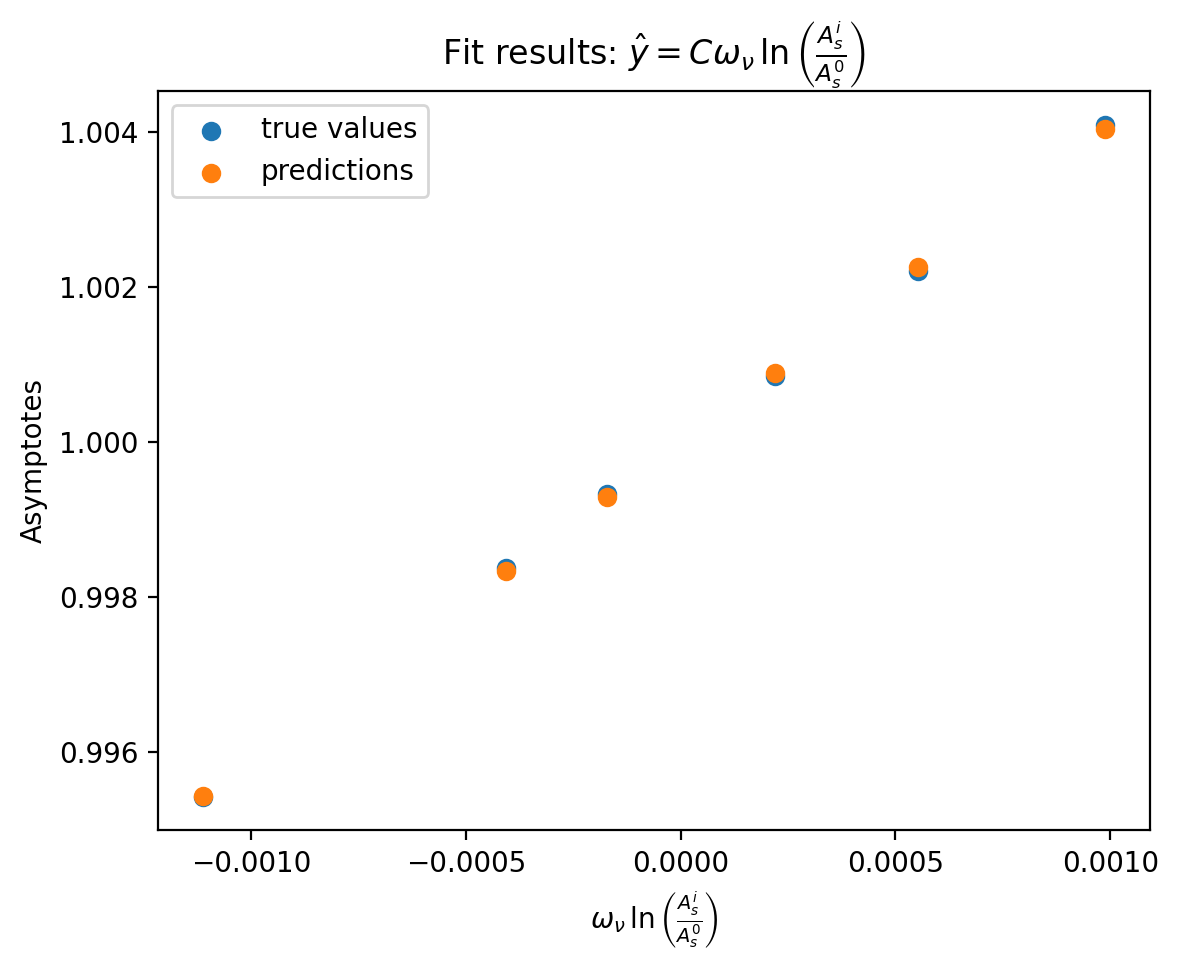

In [60]:
x6 = onh2 * np.log(A_s[1:] / A_s[0])
model_desc_6 = r"\omega_\nu \, \ln \left( \frac{A_s^i}{A_s^0} \right)$"

plt.scatter(x6, true_asymptotes, label="true values")

b6, m6 = polyfit(x6, true_asymptotes, 1)

pred6 = m6 * x6 + b6
plt.scatter(x6, pred6, label="predictions")

print("y-intercept for this fit is", b6)
print("slope for this fit is", m6)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_6)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_6)
plt.legend()

chis6 = (true_asymptotes - pred6) ** 2 / pred6
red_chisq6 = sum(chis6) / len(x6)
print("Reduced chi squared value for this fit:", red_chisq6)

In [61]:
pred6

array([0.995442  , 1.00404125, 1.00226258, 0.99833375, 0.99929689,
       1.00089562])

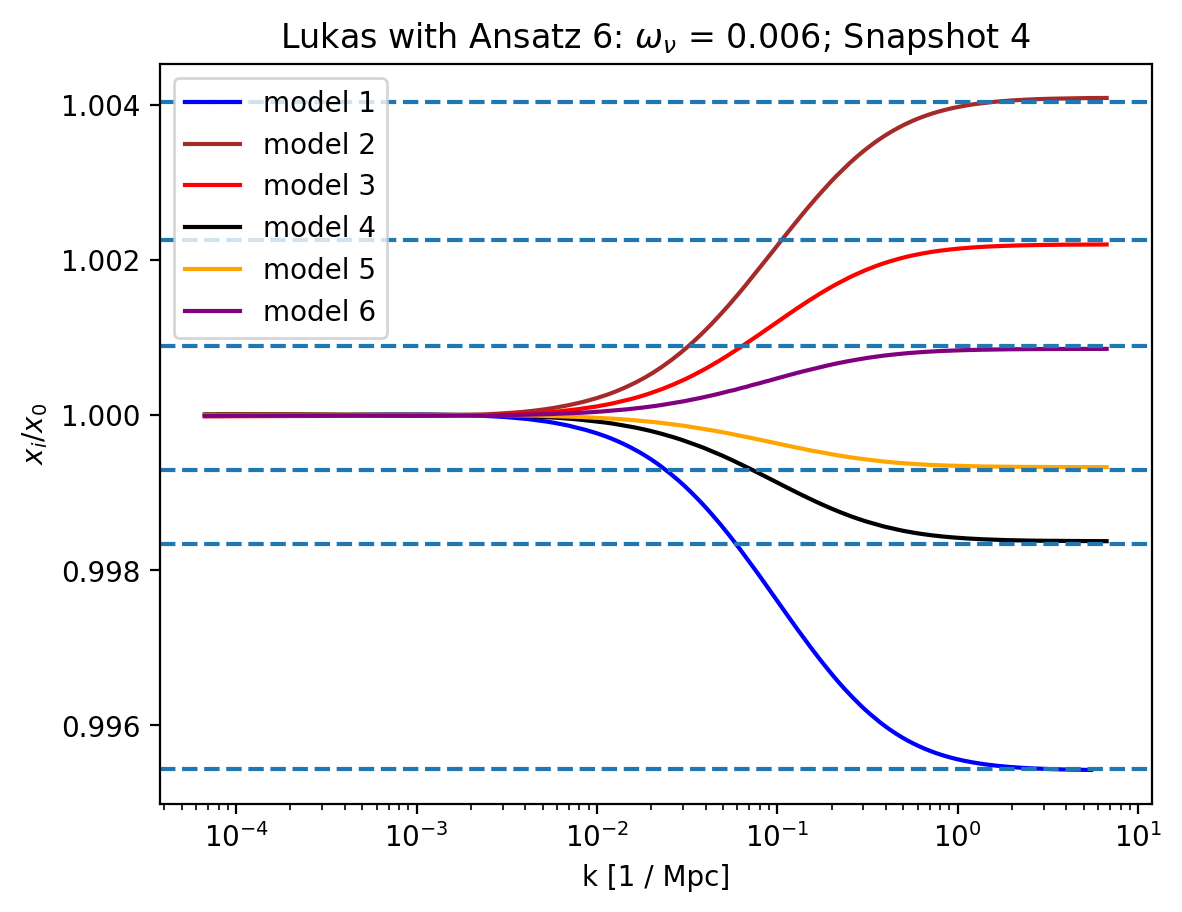

In [62]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title=dTitle + " with Ansatz 6")
#axs.get_legend().remove()
for i in range(len(true_asymptotes)):
    axs.axhline(m6 * x6[i] + b6, linestyle='--')